# Data Cleaning process


In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")
import json
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

In [2]:
def log_writer(logfile,content):
    with open(logfile,'a') as file_handler:
        current_time = datetime.datetime.now()
        file_handler.write(str(current_time)+ " " + content + "\n")

In [3]:
def data_clean(df):
    df["ts"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S %Z', errors='coerce')
    mask = df.ts.isnull()
    if mask.sum():
        df.loc[mask, "ts"] = pd.to_datetime(df[mask]["timestamp"], format='%Y-%m-%d %H:%M:%S.%f %Z',errors='coerce')
        df['timestamp']=df['ts']
        df.drop(columns={'ts'},inplace=True)
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
    try:    
        df.drop(columns = {"plant","rnoc_tag_name","value_type","quality"},inplace=True)
    except KeyError:
#         content = " the columns plant,rnoc_tag_name,value_type,quality are not present in the data"
#         log_writer(approot,content)
        print(" columns not found")
    
    new_df = df.pivot_table(index = "timestamp",columns="source_id_neuron",values = "value_float",dropna=False)
    new_df = new_df.reset_index()
#     content = "converted the table to have multiple columns"
#     log_writer(approot,content)
    if new_df['timestamp'].dtypes=='datetime64[ns, UTC]':
        new_df.set_index(new_df['timestamp'],inplace=True)
        new_df = new_df.tz_convert('Asia/Kolkata')
        #new_df.drop(columns = "timestamp",inplace=True)
    return new_df

In [4]:
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

In [5]:
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM

    for i in range(max(0, g-step),min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step),min(SOM.shape[1], h+step)):
            x_dis=np.square(i - g)
            y_dis=np.square(j - h)
            dist_sq = x_dis + y_dis
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:]) 
    return SOM

In [6]:
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .01, radius_decay = .01, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
   
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)  
    return SOM

In [7]:
def train_SOM_cluster(train_set1,lr):
    clust = []
    for n in range(3):
        SOM = np.random.uniform(low=0.0, high=1.0, size=(25,25,len(train_set1.columns)-1))
        # remove
        print(SOM.shape)
        a=train_set1.loc[train_set1['Group'] == n]
        a.drop('Group',axis=1,inplace=True)
        SOM = train_SOM(SOM, np.array(a),lr, epochs=50)
        print(SOM)
        clust.append(SOM)
    return clust

In [86]:
def test_model(clust,model):
# include data_set1 also
    X_test = final_df.iloc[int(len(final_df) * .7):]
    df = final_df.iloc[int(len(final_df) * .7):]
    
    X_test.reset_index('timestamp',inplace=True)
    df.reset_index('timestamp',inplace=True)
    
    df.drop('timestamp',axis=1,inplace=True)
    X_test.drop('timestamp',axis=1,inplace=True)
    
    test=X_test.copy()
    train_set1 = df.copy()

    
    
    testing_columns = ['/GHANI_531C/CTR/WMS/RADIATION_GII', '/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY']
    i=0 
    for column in test.columns:
        test[column] = test[column] / train_set1[column].abs().max()
    for col_endwith in testing_columns:
        for col in test.columns:
            if col.endswith(col_endwith):
                test[col].iloc[i*40:(i*40+20)] = np.nan
                i+=1
    missing = ~np.isfinite(test)
    mu = np.nanmean(test, 0, keepdims=1)
    Test10 = np.where(missing, mu, test)
    label = model.predict(Test10)

 
    for i in range(len(label)):
        c=label[i]
        coor=find_BMU(clust[c],Test10[i].reshape(1,X_test.shape[1]))
        a=coor[0]
        b=coor[1]
        for j in range(test.shape[1]):
            if missing.values[i][j]==True:
                vector=clust[c][a][b]
                Test10[i][j] = vector[j]

    Final= pd.DataFrame(Test10, columns =df.columns)
    for column in Final.columns:
        Final[column] = Final[column] * train_set1[column].abs().max()

    
    
    Root_Mean_Squared_Error = 0
    for col_endwith in testing_columns:
        for col in Final.columns:
            if col.endswith(col_endwith):
                Root_Mean_Squared_Error = Root_Mean_Squared_Error + np.sqrt(mean_squared_error(Final[col], X_test[col]))
                print(" RMSE "+str(Root_Mean_Squared_Error))
    
    return Final,X_test,missing,(Root_Mean_Squared_Error / len(testing_columns))

In [72]:
def Plot(Final,X_test,missing):
    testing_columns = ['/GHANI_531C/CTR/WMS/RADIATION_GII', '/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY']
    for col_endwith in testing_columns:
        for col in Final.columns:
            if col.endswith(col_endwith):
                i=list(Final[col])
                r=list(X_test[col])
                m=list(missing[col])
                miss=[]
                for j in range(len(i)):
                    if m[j]:
                        miss.append(0)
                    else:
                        miss.append(r[j])
                feat_df=pd.DataFrame(pd.DataFrame({"missing":miss,'imputed':i,"real":r}))
                feat_df.iloc[0:300].plot(subplots=False,title=col)
            
                i=list(Final[col])
                r=list(X_test[col])
                m=list(missing[col])
                miss=[]
                for j in range(len(i)):
                  if m[j]:
                    miss.append(0)
                  else:
                    miss.append(r[j])
                feat_df=pd.DataFrame(pd.DataFrame({"missing":miss,'imputed':i,"real":r}))
                feat_df.iloc[0:200].plot(subplots=False,title=col)



In [73]:
data  = pd.read_json("C:\\Users\\30028133\\Downloads\\bq-results-20211213-152823-uu1r51hy0qdt.json", lines=True)
if len(data) == 0 :
    raise ValueError("No records in the input dataset")

# remove below code as it is already added in preprocessing part
#     content = "data read"
#     log_writer(approot,content)
#     print(data.columns)
data_set1 = data.copy()
#     content = "data copied to a new variable data_set1"
#     log_writer(approot,content)
# data_set1["timestamp"] = pd.to_datetime(data_set1["timestamp"], errors='coerce')
#     content = "converted timestamp"
#     log_writer(approot,content)
pre_processed_df=data_clean(data_set1)

In [74]:
pre_processed_df

source_id_neuron                  /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  \
timestamp                                                                                           
2021-01-01 05:35:00+05:30                                                  88557.91                 
2021-01-01 05:40:00+05:30                                                  88557.91                 
2021-01-01 05:45:00+05:30                                                  88557.91                 
2021-01-01 05:50:00+05:30                                                  88557.91                 
2021-01-01 05:55:00+05:30                                                  88557.91                 
...                                                                             ...                 
2021-11-30 17:39:54.775000+05:30                                                NaN                 
2021-11-30 17:40:54.696000+05:30                                                NaN                 
2021-11-30 17:41:54.657000+05:30                                                NaN                 
2021-11-30 17:42:54.686000+05:30                                                NaN                 
2021-11-30 17:43:54.661000+05:30                                                NaN                 

source_id_neuron                  /GHANI_531C/CTR/WMS/RADIATION_GHI  \
timestamp                                                             
2021-01-01 05:35:00+05:30                                      0.00   
2021-01-01 05:40:00+05:30                                      0.00   
2021-01-01 05:45:00+05:30                                      0.00   
2021-01-01 05:50:00+05:30                                      0.00   
2021-01-01 05:55:00+05:30                                      0.00   
...                                                             ...   
2021-11-30 17:39:54.775000+05:30                               2.76   
2021-11-30 17:40:54.696000+05:30                               1.26   
2021-11-30 17:41:54.657000+05:30                               0.38   
2021-11-30 17:42:54.686000+05:30                               0.02   
2021-11-30 17:43:54.661000+05:30                               0.00   

source_id_neuron                  /GHANI_531C/CTR/WMS/RADIATION_GII  
timestamp                                                            
2021-01-01 05:35:00+05:30                                  0.333333  
2021-01-01 05:40:00+05:30                                  0.333333  
2021-01-01 05:45:00+05:30                                  0.333333  
2021-01-01 05:50:00+05:30                                  0.333333  
2021-01-01 05:55:00+05:30                                  0.333333  
...                                                             ...  
2021-11-30 17:39:54.775000+05:30                           2.320000  
2021-11-30 17:40:54.696000+05:30                           0.840000  
2021-11-30 17:41:54.657000+05:30                           0.030000  
2021-11-30 17:42:54.686000+05:30                           0.000000  
2021-11-30 17:43:54.661000+05:30                                NaN  

[469763 rows x 3 columns]

In [75]:
#----------------------------------------------------------------------------------------------------------------------
final_df = pre_processed_df.interpolate(method='time')
final_df =final_df.resample('5min').mean()
final_df = final_df.drop_duplicates()
final_df = final_df.between_time('6:30', '18:30')
#final_df.drop(['/LHS_LT_PANEL/MFM_LT_PANEL/IMPORT_ACTIVE_ENERGY','/RHS_LT_PANEL/MFM_LT_PANEL/IMPORT_ACTIVE_ENERGY'],axis = 1,inplace=True)
final_df.dropna(inplace=True)
# ----------------------------------------------------------------------------------------------------------------------
# for col in data_set1.columns :
#     ##  check for other columns
#     if col.endswith('REACTIVE_POWER') or col.endswith('IMPORT_ACTIVE_ENERGY'):
#           if len(data_set1[col].unique())==1:
#                 if data_set1[col].unique()==0: #i.e it has only zero value
#                     print('Only zero present in {} column'.format(col))
#                     data_set1.drop(columns = {col},inplace=True)

rand = np.random.RandomState(0)

  ## remove this code          
train_set1 = final_df.iloc[0:int(len(final_df) * .7)]
#print(train_set1.head())
#     content = "train data created"
#     log_writer(approot,content)

train_set1.reset_index('timestamp',inplace=True)
train_set1.drop('timestamp',axis=1,inplace=True)

for typ in train_set1.dtypes:
    if typ not in ['float64','int64']:
        raise TypeError("Only Numeric values allowed") 

# print(train_set1.max())
# print(train_set1.columns)
# print(len(train_set1.columns))

# check for different scaling method
for column in train_set1.columns:
    train_set1[column] = train_set1[column] / train_set1[column].abs().max()

    
#from sklearn.utils import shuffle
#train_set1 = shuffle(train_set1)


# train_set1.to_csv("train_data.csv",index=False)
#     content = "executing KMeans"
#     log_writer(approot,content)
# train_set1.to_csv('train_set1.csv',index=False)

In [76]:
train_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31925 entries, 0 to 31924
Data columns (total 3 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  31925 non-null  float64
 1   /GHANI_531C/CTR/WMS/RADIATION_GHI                                31925 non-null  float64
 2   /GHANI_531C/CTR/WMS/RADIATION_GII                                31925 non-null  float64
dtypes: float64(3)
memory usage: 748.4 KB


In [77]:
train_set1.describe()

source_id_neuron  /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  \
count                                                  31925.000000                 
mean                                                       0.915862                 
std                                                        0.054025                 
min                                                        0.815844                 
25%                                                        0.869238                 
50%                                                        0.920123                 
75%                                                        0.964557                 
max                                                        1.000000                 

source_id_neuron  /GHANI_531C/CTR/WMS/RADIATION_GHI  \
count                                  31925.000000   
mean                                       0.336261   
std                                        0.251709   
min                                        0.000000   
25%                                        0.100264   
50%                                        0.304906   
75%                                        0.568293   
max                                        1.000000   

source_id_neuron  /GHANI_531C/CTR/WMS/RADIATION_GII  
count                                  31925.000000  
mean                                       0.331452  
std                                        0.233520  
min                                        0.000000  
25%                                        0.120379  
50%                                        0.306045  
75%                                        0.506305  
max                                        1.000000

In [78]:
train_set1['/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY'].unique()

array([0.81584438, 0.81584475, 0.81584521, ..., 0.99998204, 0.9999902 ,
       1.        ])

In [79]:
train_set1['/GHANI_531C/CTR/WMS/RADIATION_GHI'].unique()

array([0.00000000e+00, 4.10497605e-04, 1.84723922e-03, ...,
       4.14240521e-01, 5.70659697e-01, 5.83628260e-01])

In [80]:
train_set1['/GHANI_531C/CTR/WMS/RADIATION_GHI'].unique()

array([0.00000000e+00, 4.10497605e-04, 1.84723922e-03, ...,
       4.14240521e-01, 5.70659697e-01, 5.83628260e-01])

In [81]:
km = KMeans(n_clusters=3, random_state=0, n_init=30)
km.fit(train_set1)
label = km.predict(train_set1)
train_set1['Group'] = label
train_set1['Group'].value_counts()
#     content = "k-means label assigned"
#     log_writer(approot,content)

print('Saving pickle file.')
filename = 'final_WMS_km_01.sav'

Saving pickle file.


In [82]:
train_set1.Group.unique()

array([1, 0, 2])

In [83]:
train_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31925 entries, 0 to 31924
Data columns (total 4 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  31925 non-null  float64
 1   /GHANI_531C/CTR/WMS/RADIATION_GHI                                31925 non-null  float64
 2   /GHANI_531C/CTR/WMS/RADIATION_GII                                31925 non-null  float64
 3   Group                                                            31925 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 873.1 KB


In [87]:
pickle.dump(km, open(filename, 'wb'))
#     content = "pickle file saved"
#     log_writer(approot,content)

learning_rate = [0.01,0.07,0.1,0.2] 
rmse_list     = []

cluster = [] 
for lr in learning_rate:
    #print('Testing for learning rate {}. \n'.format(lr))
    clust = []
    #print('Forming SOM cluster...')
    clust = train_SOM_cluster(train_set1,lr)
    #print(clust)

    print('Finding RMSE value for learning rate {}.'.format(lr))
    Final,X_test,missing,rmse = test_model(clust,km)
    rmse_list.append(rmse)
print('Final RMSE list : ',rmse_list)
final_lr = learning_rate[rmse_list.index(min(rmse_list))]
print('Best learning rate: ',final_lr)
#     content = "Finding final learning rate from given RMSE list"
#     log_writer(approot,content)

#     content = "Saving model files for best learning rate found"
clust = train_SOM_cluster(train_set1,final_lr)
print('Saving weighted matrix into numpy.')
np.save("final_WMS_weights_01",np.array(clust))
#     log_writer(approot,content)

(25, 25, 3)
[[[3.98308539e-01 5.22957071e-01 3.06105414e-01]
  [2.39828099e-01 6.04481069e-01 2.02815697e-01]
  [9.67529138e-01 8.00257977e-01 9.14374056e-01]
  ...
  [8.44661322e-01 5.64883666e-01 4.06257631e-01]
  [7.94192813e-01 5.21714687e-01 4.44551118e-01]
  [5.34716127e-01 6.45692534e-01 5.58023673e-01]]

 [[1.82412377e-01 8.29071435e-01 1.31967993e-01]
  [2.41727306e-01 8.74482857e-01 7.63791892e-01]
  [9.76259487e-02 7.88035601e-01 4.09501818e-01]
  ...
  [8.44099794e-01 5.63178129e-01 3.95269857e-01]
  [8.35251502e-01 5.63629569e-01 3.99234792e-01]
  [7.68345891e-01 5.33932317e-01 4.49962400e-01]]

 [[2.91204905e-01 3.50037892e-02 2.21997691e-01]
  [9.18341459e-01 6.04070514e-01 2.08350114e-01]
  [7.63556352e-01 6.40040117e-01 4.19394266e-01]
  ...
  [8.36663258e-01 5.54231326e-01 3.96839425e-01]
  [8.28725266e-01 5.53752083e-01 4.04899162e-01]
  [8.18719235e-01 5.58177905e-01 4.09704288e-01]]

 ...

 [[9.75687050e-01 3.92812532e-02 5.99926219e-01]
  [9.75401687e-01 4.6912365

[[[0.93674811 0.75010311 0.73883333]
  [0.93724275 0.75776804 0.74437126]
  [0.93516383 0.77199668 0.75503697]
  ...
  [0.84943124 0.6116229  0.42339793]
  [0.84947865 0.59855298 0.4144564 ]
  [0.84954041 0.58796746 0.40751238]]

 [[0.92965197 0.75060272 0.73818088]
  [0.93103911 0.75947296 0.742742  ]
  [0.93102793 0.77399532 0.75042486]
  ...
  [0.84257632 0.60800984 0.42622378]
  [0.84332902 0.59540468 0.41845477]
  [0.84348688 0.58531955 0.41220853]]

 [[0.91913836 0.75002483 0.74045681]
  [0.921271   0.75998757 0.74335432]
  [0.92672384 0.77405026 0.74674583]
  ...
  [0.83316771 0.60475892 0.43103712]
  [0.83379877 0.59278325 0.42335352]
  [0.83438398 0.58354633 0.41737522]]

 ...

 [[0.8668618  0.70374317 0.72936266]
  [0.86932753 0.70008256 0.72253747]
  [0.87253236 0.69431419 0.71348953]
  ...
  [0.87539311 0.60457784 0.62492214]
  [0.86767566 0.60252109 0.61866269]
  [0.86619574 0.60460984 0.6145161 ]]

 [[0.8646999  0.69776445 0.72530871]
  [0.86589841 0.69427907 0.71884176]


[[[0.8456198  0.57803855 0.40567913]
  [0.84668651 0.58644112 0.41001854]
  [0.84688875 0.60089382 0.41812148]
  ...
  [0.89004084 0.79139821 0.80156716]
  [0.87756378 0.79855877 0.81839002]
  [0.87389744 0.80356285 0.82722266]]

 [[0.83773298 0.57479155 0.41189268]
  [0.8398194  0.585639   0.4160111 ]
  [0.84182644 0.60148209 0.42261954]
  ...
  [0.88426007 0.78363631 0.79713018]
  [0.87639561 0.79078329 0.81036143]
  [0.87336505 0.7939013  0.81773411]]

 [[0.82659855 0.57456882 0.41855255]
  [0.83003002 0.58715454 0.42335967]
  [0.83576812 0.60542397 0.42980915]
  ...
  [0.88065609 0.76610479 0.78439954]
  [0.87551029 0.77272576 0.79555657]
  [0.87106741 0.77323796 0.80005321]]

 ...

 [[0.92589466 0.74826032 0.72352606]
  [0.93181799 0.74169386 0.72329773]
  [0.95013924 0.72018831 0.71187357]
  ...
  [0.89149425 0.50803523 0.52255218]
  [0.87891071 0.50874028 0.52401933]
  [0.8709456  0.51056802 0.52192096]]

 [[0.92673894 0.74113122 0.71795542]
  [0.93592759 0.73273127 0.71736965]


Plotting the graphs...


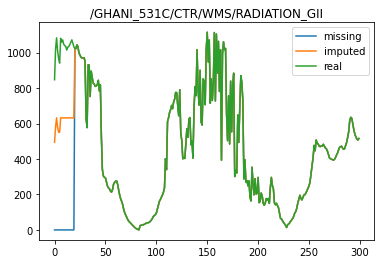

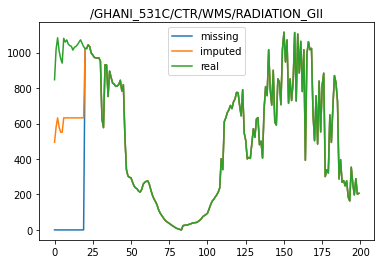

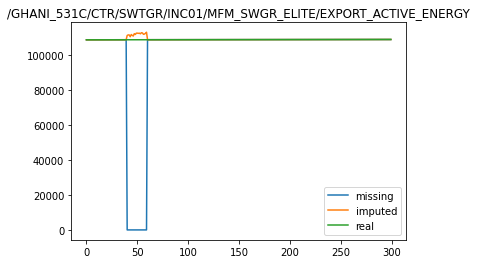

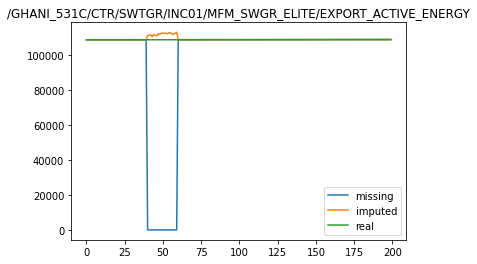

In [88]:
print('Plotting the graphs...')
Plot(Final,X_test,missing)
#         trafo_data.to_json("final_preprocessed_trafo_blk04.json")
